In [28]:
import sys
sys.path.append("../../")

import torch
import matplotlib.pyplot as plt

from diffusers import AutoencoderKL, DDPMScheduler
from torchvision.utils import make_grid
from torchvision.transforms.functional import to_pil_image

if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
elif torch.backends.mps.is_available():
    DEVICE = torch.device("mps")
else:
    DEVICE = torch.device("cpu")
print(f"Using device: {DEVICE}")


CHECKPOINT_PATH = "../../color_diffusion_cond_checkpoints/unet_epoch_8.pt"

vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae")
vae.eval().to(DEVICE)
for p in vae.parameters():
    p.requires_grad_(False)

def create_small_unet(num_colors):
    from diffusers import UNet2DConditionModel
    model = UNet2DConditionModel(
        sample_size=64,
        in_channels=4,
        out_channels=4,
        down_block_types=(
            "CrossAttnDownBlock2D",
            "CrossAttnDownBlock2D",
        ),
        mid_block_type="UNetMidBlock2DCrossAttn",
        up_block_types=(
            "CrossAttnUpBlock2D",
            "CrossAttnUpBlock2D",
        ),
        block_out_channels=(128, 256),
        layers_per_block=2,
        cross_attention_dim=num_colors,  # must match training
    )
    return model

NUM_COLORS = 10  # black, blue, brown, green, grey, orange, red, violet, white, yellow

unet = create_small_unet(num_colors=NUM_COLORS).to(DEVICE)

checkpoint = torch.load(CHECKPOINT_PATH, map_location="cpu")
unet.load_state_dict(checkpoint)
unet.eval()

scheduler = DDPMScheduler(num_train_timesteps=1000)

def sample_one_hot_cfg(
    label_id,
    guidance_scale=7.5,
    num_samples=4,
    num_inference_steps=50
):
    unet.eval()
    with torch.no_grad():
        # Create unconditional (zeros) & conditional (one-hot) embeddings
        cond = torch.zeros((num_samples, NUM_COLORS), device=DEVICE)
        cond[range(num_samples), label_id] = 1.0
        cond = cond.unsqueeze(1)  # shape [bs, 1, num_colors]

        uncond = torch.zeros_like(cond)  # unconditional

        latents = torch.randn((num_samples, 4, 64, 64), device=DEVICE)
        scheduler.set_timesteps(num_inference_steps)

        for t in scheduler.timesteps:
            uncond_out = unet(latents, t, encoder_hidden_states=uncond).sample
            cond_out   = unet(latents, t, encoder_hidden_states=cond).sample
            cfg_out = uncond_out + guidance_scale * (cond_out - uncond_out)

            latents = scheduler.step(cfg_out, t, latents).prev_sample

        images = vae.decode(latents / 0.18215).sample

    images = (images * 0.5 + 0.5).clamp(0, 1)
    return images

Using device: mps


In [29]:
def generate_color_images(
    color_name,
    color_to_id,
    unet,
    vae,
    scheduler,
    device,
    num_samples=4,
    guidance_scale=7.5,
    num_inference_steps=50
):
    """
    Returns a list of PIL images generated by the one-hot + CFG model for the specified color_name.
    """
    unet.eval()
    label_id = color_to_id[color_name]
    images_pil = []

    with torch.no_grad():
        num_colors = unet.config.cross_attention_dim
        cond = torch.zeros((num_samples, num_colors), device=device)
        cond[range(num_samples), label_id] = 1.0
        cond = cond.unsqueeze(1)  # [bs, 1, num_colors]

        uncond = torch.zeros_like(cond)

        latents = torch.randn((num_samples, 4, 64, 64), device=device)
        scheduler.set_timesteps(num_inference_steps)

        for t in scheduler.timesteps:
            uncond_out = unet(latents, t, encoder_hidden_states=uncond).sample
            cond_out   = unet(latents, t, encoder_hidden_states=cond).sample
            cfg_out = uncond_out + guidance_scale * (cond_out - uncond_out)

            latents = scheduler.step(cfg_out, t, latents).prev_sample

        decoded = vae.decode(latents / 0.18215).sample
        decoded = (decoded * 0.5 + 0.5).clamp(0, 1)

    for i in range(num_samples):
        # Each image is (3, H, W)
        img_tensor = decoded[i]
        pil_img = to_pil_image(img_tensor)
        images_pil.append(pil_img)

    return images_pil

import matplotlib.pyplot as plt

def display_samples(images_pil, title="Generated Samples"):
    """
    Displays a list of PIL images in a single row.
    """
    num_images = len(images_pil)
    plt.figure(figsize=(3 * num_images, 3))  # Wider figure for multiple images
    for i, img_pil in enumerate(images_pil):
        plt.subplot(1, num_images, i+1)
        plt.imshow(img_pil)
        plt.axis("off")
    plt.suptitle(title)
    plt.show()

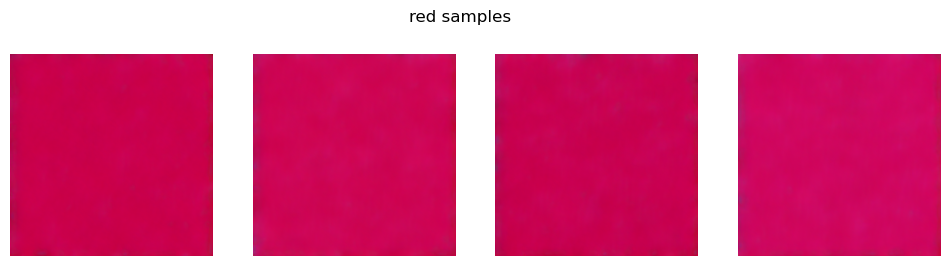

In [30]:
# color_to_id: {'black': 0, 'blue': 1, 'brown': 2, 'green': 3, 'grey': 4, 'orange': 5, 'red': 6, 'violet': 7, 'white': 8, 'yellow': 9}
colors = ["black", "blue", "brown", "green", "grey",
          "orange", "red", "violet", "white", "yellow"]

color_to_id = {c: i for i, c in enumerate(colors)}

my_color = "red"
imgs = generate_color_images(
    color_name=my_color,
    color_to_id=color_to_id,
    unet=unet,
    vae=vae,
    scheduler=scheduler,
    device=DEVICE,
    num_samples=4,
    guidance_scale=10.0,
    num_inference_steps=10
)

display_samples(imgs, title=f"{my_color} samples")

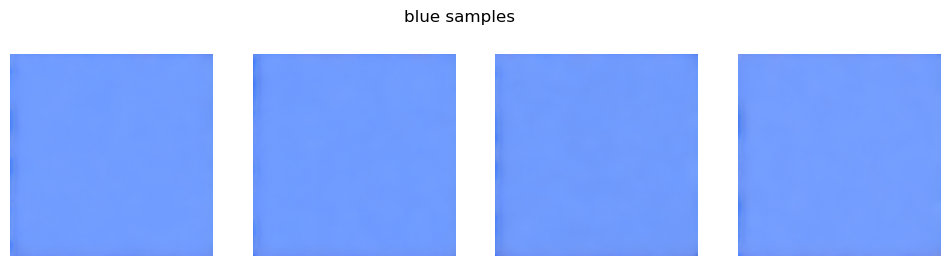

In [31]:
my_color = "blue"
imgs = generate_color_images(
    color_name=my_color,
    color_to_id=color_to_id,
    unet=unet,
    vae=vae,
    scheduler=scheduler,
    device=DEVICE,
    num_samples=4,
    guidance_scale=10.0,
    num_inference_steps=10
)

display_samples(imgs, title=f"{my_color} samples")

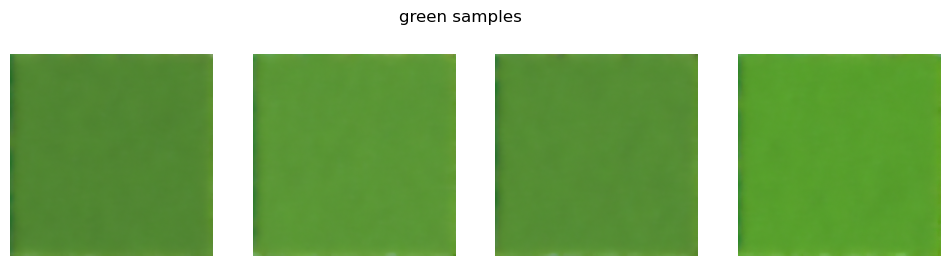

In [32]:
my_color = "green"
imgs = generate_color_images(
    color_name=my_color,
    color_to_id=color_to_id,
    unet=unet,
    vae=vae,
    scheduler=scheduler,
    device=DEVICE,
    num_samples=4,
    guidance_scale=10.0,
    num_inference_steps=10
)

display_samples(imgs, title=f"{my_color} samples")

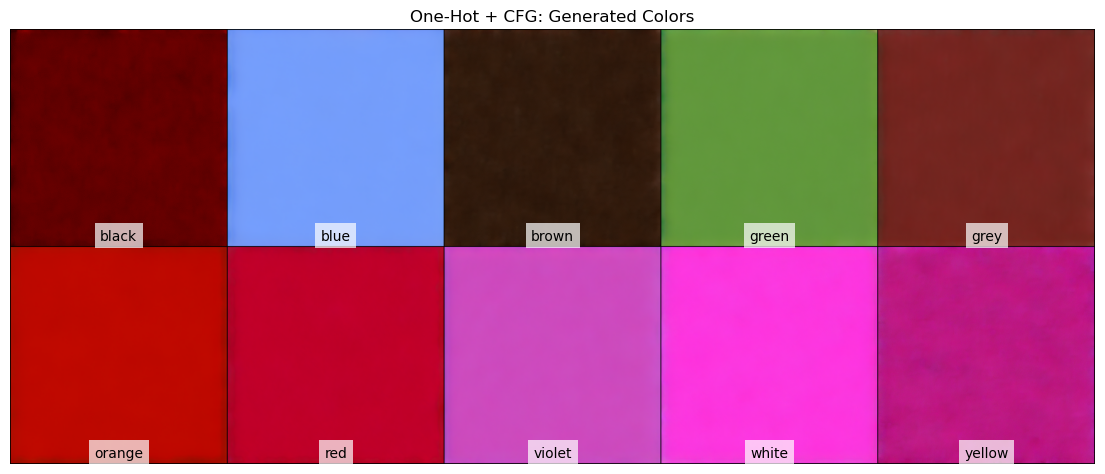

In [33]:


all_images = []
for color in colors:
    label_id = color_to_id[color]
    # Sample with CFG
    images = sample_one_hot_cfg(
        label_id=label_id,
        guidance_scale=7.5,      # or another scale
        num_samples=1,
        num_inference_steps=20,  # increase for better quality
    )
    all_images.append(images[0])

combined_grid = make_grid(torch.stack(all_images, dim=0), nrow=5)
combined_grid_pil = to_pil_image(combined_grid)

plt.figure(figsize=(14, 6))
plt.imshow(combined_grid_pil)

# Optionally label them
num_cols = 5
img_width = combined_grid_pil.width / num_cols
img_height = combined_grid_pil.height / (len(colors) / num_cols)

for idx, color in enumerate(colors):
    row = idx // num_cols
    col = idx % num_cols
    x = col * img_width + img_width/2
    y = (row + 1) * img_height - 10
    plt.text(x, y, color, ha='center', va='bottom', color='black',
             bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))

plt.title("One-Hot + CFG: Generated Colors")
plt.axis("off")
plt.show()